# Langgraph 搭配千帆 Adpater 使用

LangGraph 是由 LangChain Inc. 所推出的一款大模型应用编排框架。它在集成了来自 LangChain 的功能的同时，还提供了通过代码构建有向无环图（DAG），将多个智能体（Agent）或工具（Tool）节点链接在一起，在之间传递数据状态并且最终得出用户期望的输出结果的能力。LangGraph 官方提供了数种使用 LangGraph 来构建应用的样例，下文将介绍如何将这些样例与千帆 Adpater 结合使用，以实现现有 LangGraph 与 ERNIE 系列大模型的无缝对接。

# 准备工作

需要安装最新版本的 LangGraph 和 LangChain，并安装千帆 Adpater 版本的额外依赖组。

In [1]:
!pip install -U langchain langchain-community langchain_openai langgraph duckduckgo "qianfan[openai]"
!qianfan --version

接下来将演示如何使用 LangGraph 构建一个多智能体合作的 Demo

# 0. 设置

在开始之前，我们需要设置一些运行时必须的环境变量

In [2]:
import os

# 由于 langchain-openai 的运行逻辑强校验 OPENAI_API_KEY 的存在，因此需要提前设置好
# 值可以随便设置
os.environ['OPENAI_API_KEY'] = 'any-content-you-want'

# 这里需要设置为千帆 Adapter 运行时的地址
os.environ['OPENAI_BASE_URL'] = 'http://localhost:8001/v1'

并且在一个独立的终端中使用 `qianfan openai` 来启动一个 Adapter。这个 Adpater 会将所有请求向 OpenAI 的 API 转换为对千帆平台的请求，并且将回包转换为 OpenAI 的回包格式。实现在现有 OpenAI 生态中快速切换到千帆能力上的功能

# 1. 创建 Agent

LangGraph 中的节点可以是多种类型，例如一个被构造为智能体的 Chain。下面我们定义了一个工具函数，用于帮助我们快速构建一个支持传入 tools 和 system 字段作为请求参数的简易 Agent

In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(tools)

# 2. 定义工具

Agent 的构造除了要使用大模型，还需要传入其可以使用的工具。下面我们就定义了一个用于执行 Python 脚本的解释器工具，和用于获取 mock 数据的搜索工具

In [4]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

@tool
def duckduckgo_search(
    query: Annotated[str, "搜索关键词"],
):
    """使用该工具来搜索 DuckDuckGo 上的内容."""
    return """{
  "GDP_USA_2010_2020": {
    "2010": 14964.4,
    "2011": 15518.9,
    "2012": 16197.0,
    "2013": 16784.9,
    "2014": 17527.3,
    "2015": 18224.8,
    "2016": 18745.1,
    "2017": 19519.4,
    "2018": 20611.9,
    "2019": 21433.2,
    "2020": 20936.6
  }
}"""

# 3. 创建 Graph

现在我们有了工具的定义，以及构建 Agent 的工具函数，接下来我们就可以着手来构建 LangGraph 的 Graph。Graph 中的每个节点代表一个 Agent，每个节点之间的边代表两个 Agent 之间的通信。Graph 的作用是描述 Agent 之间的通信，从而帮助我们构建 Agent 之间的交互。

## 3.1 定义状态

我们首先需要定义 Graph 的状态。这个状态包含了一个消息列表，以及一个用来追踪最近发送消息节点的 Key

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

## 3.2 定义 Agent 节点

在定义了状态之后，我们接下来就需要定义用于构建 Graph 的节点了。首先是 Agent 节点

In [6]:
import functools
import re

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    messages = state["messages"]
    last_message = messages[-1]

    if isinstance(last_message, AIMessage):
        messages.append(HumanMessage(content="Please continue your thinking"))
        state["messages"] = messages

    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

def extract_markdown_code_blocks(text):
    code_block_pattern = re.compile(r'```python(.*?)```', re.DOTALL)

    code_blocks = code_block_pattern.findall(text)
    
    return code_blocks


# Helper function to create a code node for a given agent
def code_agent_node(state, agent, name):
    messages = state["messages"]
    last_message = messages[-1]

    if isinstance(last_message, AIMessage):
        messages.append(HumanMessage(content="Please continue your thinking"))
        state["messages"] = messages

    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    
    from langchain_core.messages import ToolCall

    code_blocks = extract_markdown_code_blocks(result.content)
    if code_blocks:
        code_block = code_blocks[0]
        result = AIMessage(content="", tool_calls=[ToolCall(name="python_repl", args={"code": code_block}, id="python_repl")])
    
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

llm = ChatOpenAI(model="ERNIE-Functions-8K")
llm_code_gen = ChatOpenAI(model="ERNIE-4.0-8K")

# Research agent and node
research_agent = create_agent(
    llm,
    [duckduckgo_search],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm_code_gen,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(code_agent_node, agent=chart_agent, name="chart_generator")

## 3.3 定义工具节点

除了决策用的 Agent 节点之外，我们还需要定义一个工具节点，来运行从 Agent 节点传递的调用信息

In [7]:
from langgraph.prebuilt import ToolNode

tools = [duckduckgo_search, python_repl]
tool_node = ToolNode(tools)

## 3.4 定义边

不同节点之间需要用边来链接，LangGraph 支持根据节点输出的状态，依据一定条件来构造边的行为。

In [8]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    
    return "continue"

## 3.5 定义图

在构造完上述组件之后，我们接下来可以将它们组合在一起构造为 Graph。

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

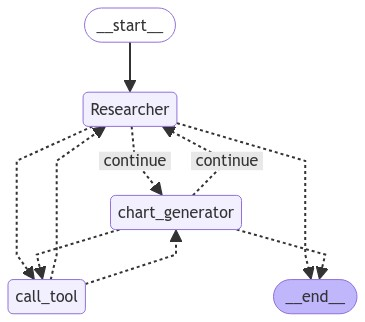

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# 4. 运行

接下来我们就可以运行了

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query": "US GDP between 2010 and 2020"}', 'name': 'duckduckgo_search'}, 'tool_calls': [{'id': 'duckduckgo_search', 'function': {'arguments': '{"query": "US GDP between 2010 and 2020"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 236, 'total_tokens': 266}, 'model_name': 'ERNIE-Functions-8K', 'system_fingerprint': 'fp_?', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-54cfe4a0-3104-4656-899e-3d750d026c10-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'US GDP between 2010 and 2020'}, 'id': 'duckduckgo_search', 'type': 'tool_call'}], usage_metadata={'input_tokens': 236, 'output_tokens': 30, 'total_tokens': 266})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='{\n  "GDP_USA_2010_2020": {\n    "2010": 14964.4

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', name='chart_generator', tool_calls=[{'name': 'python_repl', 'args': {'code': "\nimport matplotlib.pyplot as plt\n\n# GDP data for the US from 2010 to 2020 (in billions of USD)\nyears = list(range(2010, 2021))\ngdp_values = [14964.4, 15518.9, 16197.0, 16784.9, 17527.3, 18224.8, 18745.1, 19519.4, 20611.9, 21433.2, 20936.6]\n\n# Create a line graph\nplt.plot(years, gdp_values, marker='o')\n\n# Add titles and labels\nplt.title('US GDP from 2010 to 2020')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billions of USD)')\nplt.grid(True)\nplt.show()\n"}, 'id': 'python_repl', 'type': 'tool_call'}])], 'sender': 'chart_generator'}}
----


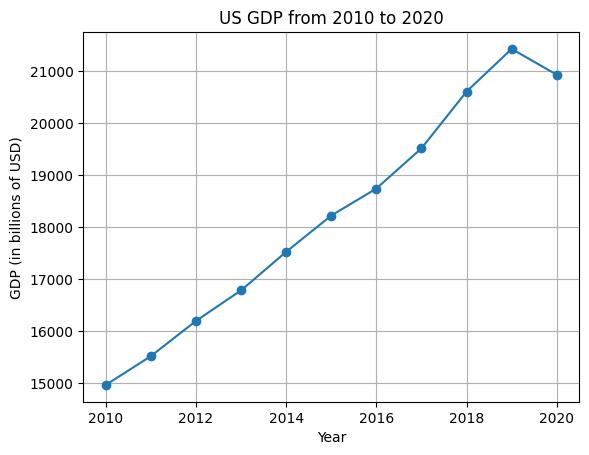

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# GDP data for the US from 2010 to 2020 (in billions of USD)\nyears = list(range(2010, 2021))\ngdp_values = [14964.4, 15518.9, 16197.0, 16784.9, 17527.3, 18224.8, 18745.1, 19519.4, 20611.9, 21433.2, 20936.6]\n\n# Create a line graph\nplt.plot(years, gdp_values, marker='o')\n\n# Add titles and labels\nplt.title('US GDP from 2010 to 2020')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billions of USD)')\nplt.grid(True)\nplt.show()\n\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='python_repl')]}}
----
{'chart_generator': {'messages': [AIMessage(content='I have created a line graph showing the US GDP from 2010 to 2020. The graph displays the trend of the GDP over this period, clearly indicating the changes from year to year. If you would like to see the graph, please let me know and I can provide it to you.\n\

In [11]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the US's GDP between 2010 and 2020,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")